In [2]:
# Import packages
import pandas as pd
import numpy as np
import datetime
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, cohen_kappa_score, f1_score
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, SMOTENC
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.decomposition import PCA
from scipy import stats
from math import sqrt



import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianNoise
from keras.optimizers import SGD
from keras import regularizers

In [3]:
path = "/Users/Stijn/Documents/Master Data Science and Society/Block 3/thesis/code/thesis_Code/"
mood = pd.read_csv(path+'mood_imputed_median.csv', sep = ',', index_col=0)
mood_cheerful = mood.copy()

In [5]:
mood_cheerful['cheerful'].value_counts()

3.0    3719
2.0    2966
4.0    2358
1.0    1880
0.0    1413
5.0     885
Name: cheerful, dtype: int64

In [6]:
cheerfulR2 = []
for a in mood['cheerful']:
    if a == 0:
      cheerfulR2.append(0)  
    if a == 1:
      cheerfulR2.append(2)
    if a == 2:
      cheerfulR2.append(3)
    if a == 3:
      cheerfulR2.append(4)
    if a == 4:
      cheerfulR2.append(5)
    if a == 5:
      cheerfulR2.append(7)
mood_cheerful['cheerfulR2'] = cheerfulR2
mood_cheerful = mood_cheerful.drop(['cheerful'], axis=1)

In [8]:
mood_cheerful['cheerful_last'] = mood_cheerful.groupby('user_id')['cheerfulR2'].shift()
mood_cheerful.loc[(pd.isnull(mood_cheerful.cheerful_last)), 'cheerful_last'] = mood_cheerful['cheerfulR2']
mood_cheerful = mood_cheerful.drop(["content", "bored", "anxious", "user_id", "response_time"], axis=1)
mood_cheerful = mood_cheerful[['cheerfulR2', 'day_time_window', 'average_TimeUse', 'bulk', 'messaging', 'socialnetworking', 'otherapp', 'cheerful_last']]

In [9]:
# Normalize predictors
mood_normz = mood_cheerful.copy()
features_to_normalize = ['day_time_window', 'average_TimeUse', 'messaging', 'socialnetworking', 'otherapp']
mood_normz[features_to_normalize] = mood_normz[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [10]:
X = mood_normz.iloc[:,1:]
y = mood_normz.iloc[:, 0:1]
y = y.astype(int)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [12]:
# Oversampling unbalanced target
print("Before OverSampling, counts of labels: {}".format(y_train['cheerfulR2'].value_counts()))
  
sm = SMOTENC(categorical_features=[0, 2, 6], random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train['cheerfulR2'].ravel()) 

print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 
print("After OverSampling, counts of label '2': {}".format(sum(y_train_res == 2))) 
print("After OverSampling, counts of label '3': {}".format(sum(y_train_res == 3))) 
print("After OverSampling, counts of label '4': {}".format(sum(y_train_res == 4))) 
print("After OverSampling, counts of label '5': {}".format(sum(y_train_res == 5))) 
print("After OverSampling, counts of label '7': {}".format(sum(y_train_res == 7))) 

Before OverSampling, counts of labels: 4    2964
3    2367
5    1901
2    1494
0    1138
7     712
Name: cheerfulR2, dtype: int64
After OverSampling, counts of label '0': 2964
After OverSampling, counts of label '2': 2964
After OverSampling, counts of label '3': 2964
After OverSampling, counts of label '4': 2964
After OverSampling, counts of label '5': 2964
After OverSampling, counts of label '7': 2964


In [13]:
X_train = pd.DataFrame(data=X_train_res)
y_train = pd.DataFrame(data=y_train_res)

In [14]:
# Shuffle both train and test set to cancel patterns
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [15]:
X_train_nomood = X_train.iloc[:,:-1]
X_train_onlylastmood = X_train.iloc[:,-1:]
X_test_nomood = X_test.iloc[:,:-1]
X_test_onlylastmood = X_test.iloc[:,-1:]

In [16]:
# Define Keras model
model = Sequential()
model.add(Dense(24, input_dim=6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                168       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train_nomood, y_train, epochs=100, validation_split=0.2, batch_size=512)

Train on 14227 samples, validate on 3557 samples
Epoch 1/100
14227/14227 [==============================] - 0s 16us/step - loss: 18.1496 - accuracy: 0.1582 - val_loss: 16.1948 - val_accuracy: 0.1695
Epoch 2/100
14227/14227 [==============================] - 0s 5us/step - loss: 15.4149 - accuracy: 0.1615 - val_loss: 13.7274 - val_accuracy: 0.1198
Epoch 3/100
14227/14227 [==============================] - 0s 5us/step - loss: 12.7553 - accuracy: 0.0392 - val_loss: 10.9006 - val_accuracy: 0.0124
Epoch 4/100
14227/14227 [==============================] - 0s 5us/step - loss: 9.7014 - accuracy: 0.0526 - val_loss: 7.8417 - val_accuracy: 0.1015
Epoch 5/100
14227/14227 [==============================] - 0s 5us/step - loss: 6.9080 - accuracy: 0.1475 - val_loss: 5.8268 - val_accuracy: 0.1732
Epoch 6/100
14227/14227 [==============================] - 0s 4us/step - loss: 5.6446 - accuracy: 0.1705 - val_loss: 5.3470 - val_accuracy: 0.1726
Epoch 7/100
14227/14227 [==============================] - 0s 

14227/14227 [==============================] - 0s 5us/step - loss: 4.8180 - accuracy: 0.1648 - val_loss: 4.7795 - val_accuracy: 0.1746
Epoch 57/100
14227/14227 [==============================] - 0s 4us/step - loss: 4.8169 - accuracy: 0.1643 - val_loss: 4.7798 - val_accuracy: 0.1743
Epoch 58/100
14227/14227 [==============================] - 0s 4us/step - loss: 4.8187 - accuracy: 0.1664 - val_loss: 4.7753 - val_accuracy: 0.1749
Epoch 59/100
14227/14227 [==============================] - 0s 4us/step - loss: 4.8163 - accuracy: 0.1636 - val_loss: 4.7775 - val_accuracy: 0.1751
Epoch 60/100
14227/14227 [==============================] - 0s 4us/step - loss: 4.8154 - accuracy: 0.1648 - val_loss: 4.7730 - val_accuracy: 0.1749
Epoch 61/100
14227/14227 [==============================] - 0s 4us/step - loss: 4.8150 - accuracy: 0.1660 - val_loss: 4.7764 - val_accuracy: 0.1729
Epoch 62/100
14227/14227 [==============================] - 0s 4us/step - loss: 4.8134 - accuracy: 0.1633 - val_loss: 4.7712 

In [18]:
score = model.evaluate(X_train_nomood, y_train, verbose=0)
print('Test loss:', round(score[0],4))
print('Test accuracy:', round(score[1]*100,2), "%")

Test loss: 4.768
Test accuracy: 16.54 %


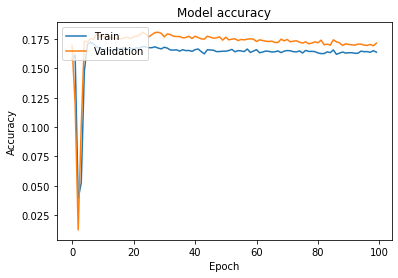

In [19]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

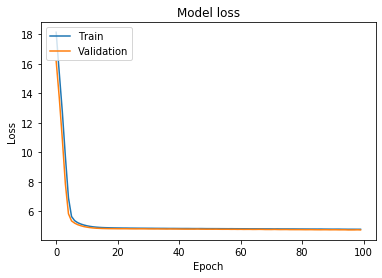

In [20]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
y_pred = model.predict(X_test_nomood)

In [22]:
cat_list = [0,2,3,4,5,7]
pred = []
for a in y_pred:
    for b in a:
        d = min(cat_list, key=lambda x:abs(x-b))
        pred.append(round(d))    

test = []
for c in y_test['cheerfulR2']:
    test.append(c)

In [23]:
test[:5]

[7, 5, 5, 3, 0]

In [24]:
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

Accuracy is: 26.12476370510397


In [25]:
# true = y_test
# pred = y_pred
# last_value = X_bored_lastarray
same_correct = 0
same_wrong = 0
dif_correct = 0
dif_wrong = 0

X_test_bored = X_test_onlylastmood['cheerful_last'].values
for i in range(len(pred)):
    if (test[i] == X_test_bored[i]) and (test[i] == pred[i]):
        same_correct += 1
    if (test[i] == X_test_bored[i]) and (test[i] != pred[i]):
        same_wrong += 1
    if (test[i] != X_test_bored[i]) and (test[i] == pred[i]):
        dif_correct += 1
    if (test[i] != X_test_bored[i]) and (test[i] != pred[i]):
        dif_wrong += 1   

print("       ", "Same", "Dif")
print("correct", same_correct, dif_correct)
print("wrong  ", same_wrong, dif_wrong)

#Check if table is similar to accuracy
if (same_correct+dif_correct) / (same_correct+dif_correct+same_wrong+dif_wrong) == a:
    print("Table is right!")
else:
    print("Table is wrong")

        Same Dif
correct 422 269
wrong   1178 776
Table is right!


In [26]:
from collections import Counter
print("Predicted valxues: ", Counter(pred))
print("True values: ", Counter(test))
print("Previous mood:", Counter(X_test_bored))

Predicted valxues:  Counter({4: 1678, 3: 915, 2: 26, 5: 26})
True values:  Counter({4: 755, 3: 599, 5: 457, 2: 386, 0: 275, 7: 173})
Previous mood: Counter({4.0: 735, 3.0: 622, 5.0: 473, 2.0: 375, 0.0: 271, 7.0: 169})


In [27]:
same_correct_0, same_wrong_0, same_correct_1, same_wrong_1, same_correct_2, same_wrong_2, same_correct_3, same_wrong_3, same_correct_4, same_wrong_4, same_correct_5, same_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
dif_correct_0, dif_wrong_0, dif_correct_1, dif_wrong_1, dif_correct_2, dif_wrong_2, dif_correct_3, dif_wrong_3, dif_correct_4, dif_wrong_4, dif_correct_5, dif_wrong_5 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] == 0:
        if test[i] == X_test_bored[i]:
            same_correct_0 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_0 += 1
    if test[i] == 0 and pred[i] != 0:
        if test[i] == X_test_bored[i]:
            same_wrong_0 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_0 += 1

    if test[i] == 2 and pred[i] == 2:
        if test[i] == X_test_bored[i]:
            same_correct_1 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_1 += 1
    if test[i] == 2 and pred[i] != 2:
        if test[i] == X_test_bored[i]:
            same_wrong_1 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_1 += 1
        
    if test[i] == 3 and pred[i] == 3:
        if test[i] == X_test_bored[i]:
            same_correct_2 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_2 += 1
    if test[i] == 3 and pred[i] != 3:
        if test[i] == X_test_bored[i]:
            same_wrong_2 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_2 += 1
    
    if test[i] == 4 and pred[i] == 4:
        if test[i] == X_test_bored[i]:
            same_correct_3 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_3 += 1
    if test[i] == 4 and pred[i] != 4:
        if test[i] == X_test_bored[i]:
            same_wrong_3 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_3 += 1
        
    if test[i] == 5 and pred[i] == 5:
        if test[i] == X_test_bored[i]:
            same_correct_4 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_4 += 1
    if test[i] == 5 and pred[i] != 5:
        if test[i] == X_test_bored[i]:
            same_wrong_4 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_4 += 1
    
    if test[i] == 7 and pred[i] == 7:
        if test[i] == X_test_bored[i]:
            same_correct_5 += 1
        if test[i] != X_test_bored[i]:
            dif_correct_5 += 1
    if test[i] == 7 and pred[i] != 7:
        if test[i] == X_test_bored[i]:
            same_wrong_5 += 1
        if test[i] != X_test_bored[i]:
            dif_wrong_5 += 1

print("Total length: ", len(X_test_bored))

print("Same Correct 0 guesses is: ", same_correct_0)
print("Same Wrong 0 guesses is: ", same_wrong_0)
print("Dif Correct 0 guesses is: ", dif_correct_0)
print("Dif Wrong 0 guesses is: ", dif_wrong_0)
print('')
print("Same Correct 1 guesses is: ", same_correct_1)
print("Same Wrong 1 guesses is: ", same_wrong_1)
print("Dif Correct 1 guesses is: ", dif_correct_1)
print("Dif Wrong 1 guesses is: ", dif_wrong_1)
print('')
print("Same Correct 2 guesses is: ", same_correct_2)
print("Same Wrong 2 guesses is: ", same_wrong_2)
print("Dif Correct 2 guesses is: ", dif_correct_2)
print("Dif Wrong 2 guesses is: ", dif_wrong_2)
print('')
print("Same Correct 3 guesses is: ", same_correct_3)
print("Same Wrong 3 guesses is: ", same_wrong_3)
print("Dif Correct 3 guesses is: ", dif_correct_3)
print("Dif Wrong 3 guesses is: ", dif_wrong_3)
print('')
print("Same Correct 4 guesses is: ", same_correct_4)
print("Same Wrong 4 guesses is: ", same_wrong_4)
print("Dif Correct 4 guesses is: ", dif_correct_4)
print("Dif Wrong 4 guesses is: ", dif_wrong_4)
print('')
print("Same Correct 5 guesses is: ", same_correct_5)
print("Same Wrong 5 guesses is: ", same_wrong_5)
print("Dif Correct 5 guesses is: ", dif_correct_5)
print("Dif Wrong 5 guesses is: ", dif_wrong_5)

Total length:  2645
Same Correct 0 guesses is:  0
Same Wrong 0 guesses is:  199
Dif Correct 0 guesses is:  0
Dif Wrong 0 guesses is:  76

Same Correct 1 guesses is:  2
Same Wrong 1 guesses is:  219
Dif Correct 1 guesses is:  0
Dif Wrong 1 guesses is:  165

Same Correct 2 guesses is:  104
Same Wrong 2 guesses is:  254
Dif Correct 2 guesses is:  98
Dif Wrong 2 guesses is:  143

Same Correct 3 guesses is:  311
Same Wrong 3 guesses is:  140
Dif Correct 3 guesses is:  170
Dif Wrong 3 guesses is:  134

Same Correct 4 guesses is:  5
Same Wrong 4 guesses is:  254
Dif Correct 4 guesses is:  1
Dif Wrong 4 guesses is:  197

Same Correct 5 guesses is:  0
Same Wrong 5 guesses is:  112
Dif Correct 5 guesses is:  0
Dif Wrong 5 guesses is:  61


In [28]:
mae_0, mae_1, mae_2, mae_3, mae_4, mae_5 = (0,0,0,0,0,0)

for i in range(len(pred)):
    if test[i] == 0 and pred[i] != 0:
        mae_0 += (abs(test[i]-pred[i]))
    if test[i] == 2 and pred[i] != 2:
        mae_1 += (abs(test[i]-pred[i]))
    if test[i] == 3 and pred[i] != 3:
        mae_2 += (abs(test[i]-pred[i]))
    if test[i] == 4 and pred[i] != 4:
        mae_3 += (abs(test[i]-pred[i]))
    if test[i] == 5 and pred[i] != 5:
        mae_4 += (abs(test[i]-pred[i]))
    if test[i] == 7 and pred[i] != 7:
        mae_5 += (abs(test[i]-pred[i]))

cnt_0, cnt_1, cnt_2, cnt_3, cnt_4, cnt_5 = (0,0,0,0,0,0)
for z in range(len(test)):
    if test[z] == 0:
        cnt_0 += 1
    if test[z] == 2:
        cnt_1 += 1
    if test[z] == 3:
        cnt_2 += 1
    if test[z] == 4:
        cnt_3 += 1
    if test[z] == 5:
        cnt_4 += 1
    if test[z] == 7:
        cnt_5 += 1

mae_macroaverage = ((mae_0/cnt_0) + (mae_1/cnt_1) + (mae_2/cnt_2) + (mae_3/cnt_3) + (mae_4/cnt_4) + (mae_5/cnt_5)) / 6

In [29]:
print("Macro-averaged Mean Absolute error is: ", round(mae_macroaverage, 4))
print("Macro-averaged F1-score is: ", round(f1_score(test, pred, average='weighted'), 4))

Macro-averaged Mean Absolute error is:  1.8046
Macro-averaged F1-score is:  0.179


/Users/Stijn/Library/Python/3.7/lib/python/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
